# Graph Learning
## Lab 6: Spectral Embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension. We consider the  embedding based on the top eigenvectors of the transition matrix $P=D^{-1}A$.

## Import

In [93]:
from IPython.display import SVG

In [94]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [95]:
!pip install scikit-network

In [96]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [97]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [98]:
dataset = karate_club(metadata=True)

In [99]:
adjacency = dataset.adjacency
position = dataset.position
labels_true = dataset.labels

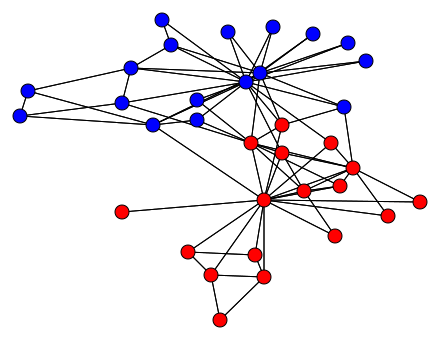

In [100]:
image = visualize_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues).
* What does the spectrum suggest?
* Display the graph with some eigenvectors.
* Display the embedding of the graph in dimension 2.
* Compare the clusters obtained with the sign of the first component of the embedding to the ground-truth clusters.

In [101]:
spectral = Spectral(20, normalized=False)

In [102]:
spectral.fit(adjacency)

Spectral(n_components=20, decomposition='rw', regularization=-1, normalized=False)

In [103]:
# eigenvalues (adding the first)
eigenvalues = [1] + list(spectral.eigenvalues_)

In [104]:
# eigenvectors
eigenvectors = spectral.eigenvectors_

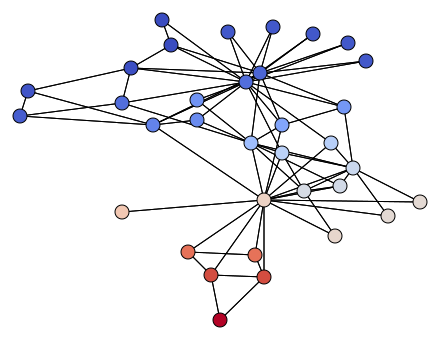

In [105]:
# display an eigenvector
image = visualize_graph(adjacency, position, scores=eigenvectors[:, 0])
SVG(image)

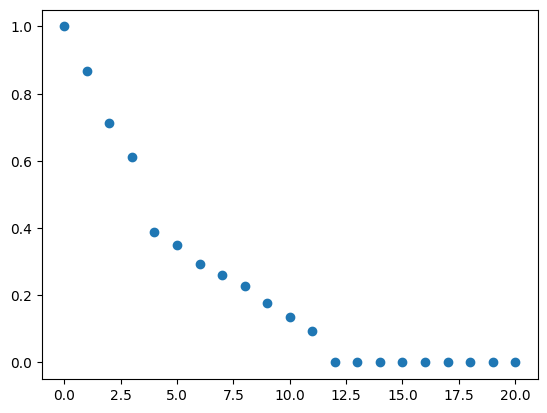

In [106]:
# spectrum
plt.scatter(range(len(eigenvalues)), eigenvalues)
plt.show()

**Answer**: The spectrum shows there is only one eigenvalue equal to 1, as there is only one connected component.

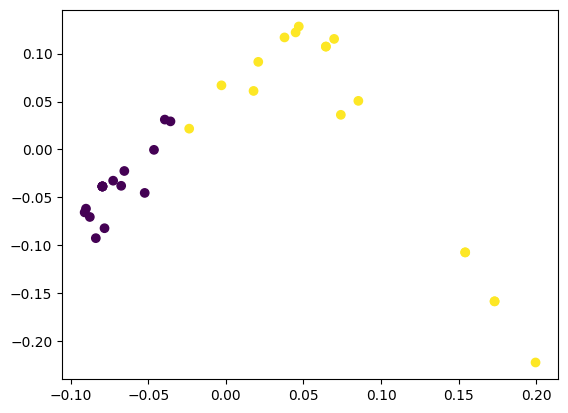

In [107]:
plt.scatter(eigenvectors[:, 0], eigenvectors[:, 1], c=labels_true)
plt.show()

**Answer**: Although it makes some mistakes, it is still a good way to cluster the graph.

## Openflights


We now consider a larger graph. We use spectral embedding in dimension 20 to cluster the graph by k-means in the embedding space.

In [108]:
dataset = openflights

In [109]:
adjacency = dataset.adjacency
position = dataset.position
names = dataset.names

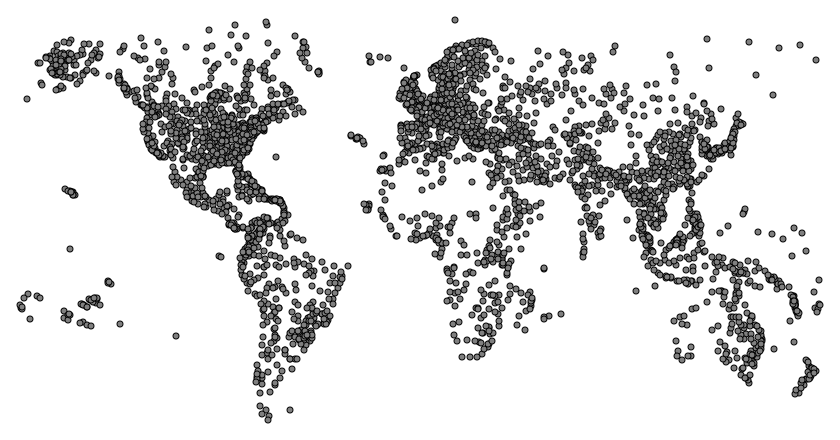

In [110]:
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the same world map with 8 clusters found by k-means in the embedding space. You can use ``scikit-learn``for k-means.
* Do the same without normalization on the unit sphere (``normalized=False``).<br> Interpret the results. <br>**Hint:** Compute the Euclidean norm of the centroid of each cluster in the embedding space.

In [111]:
spectral = Spectral(20, normalized=True)

In [112]:
embedding = spectral.fit_transform(adjacency)

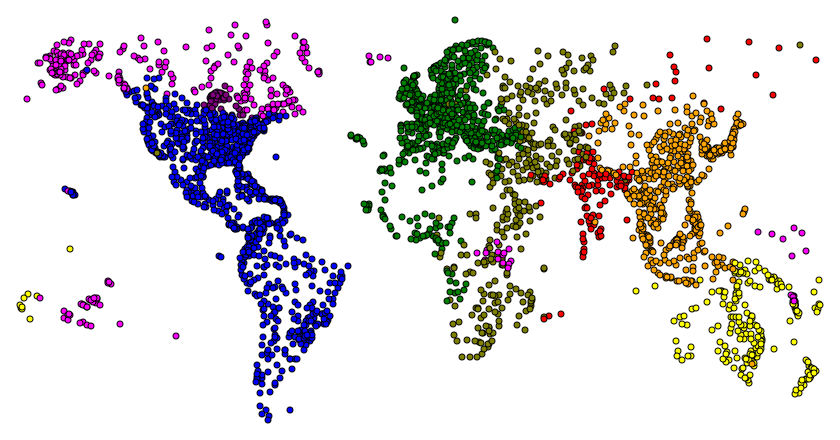

In [113]:
# k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, n_init='auto').fit(embedding)
res = kmeans.labels_
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=res)
SVG(image)

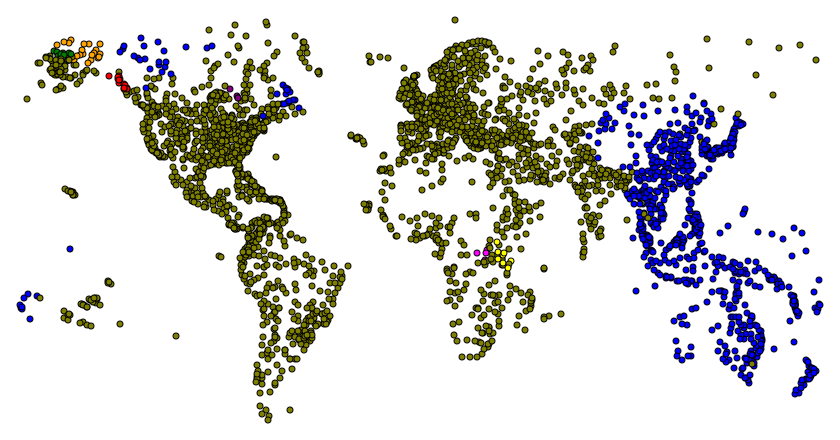

In [114]:
# no normalization
spectralNoNorm = Spectral(20, normalized=False)
embeddingNoNorm = spectralNoNorm.fit_transform(adjacency)
kmeans2 = KMeans(n_clusters=8, n_init='auto').fit(embeddingNoNorm)
resNoNorm = kmeans2.labels_
image = visualize_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False, labels=resNoNorm)
SVG(image)

**Answer**: Without normalization, nodes that poorly connected to the rest of the graph are put into the same cluster, as they were isolated by the spectral embedding.

## 2. Directed graphs and bipartite graphs

We now work on directed graph and bipartite graphs. We measure proximity between nodes in the embedding space in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we project the vectors on the unit sphere.

In [115]:
spectral = Spectral(20, normalized=True)

## Wikipedia Vitals

In [116]:
dataset = wikivitals

In [117]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
words = dataset.names_col
labels = dataset.labels
names_labels = dataset.names_labels
labels_hierarchy = dataset.labels_hierarchy
names_labels_hierarchy = dataset.names_labels_hierarchy

## To do

We first consider the spectral embedding of the graph of links in dimension 20.

* List the 20 articles that are closest to **Vincent van Gogh** in terms of cosine similarity in the embedding space. Compare with the top articles obtained with Personalized PageRank.
* Display the 3D-plot of each of the 11 labels in the embedding space (top 3 dimensions). <br>You might represent each label by a point located at the centroid of the corresponding articles, with a size proportional to the number of articles. Use ``plotly`` for an interactive plot. Interpret the results.
* Display the dendrogram of the hierarchical clustering of the top-100 articles on **Arts** (in terms of Personalized PageRank). You might use the [Ward method](https://en.wikipedia.org/wiki/Ward%27s_method) in the embedding space. Comment the results.

In [118]:
import plotly.express as px

In [119]:
from scipy.cluster.hierarchy import linkage

## To do

* Repeat the same experiments on the bipartite graph between articles and words.
* List the 10 articles and the 10 words that are closest to the word **painting** in the embedding space.

## To do

* Prove that the average cosine similarity between vectors in some set $S$ is equal to the square norm of the centroid of $S$.

$$
S=\{v_1,\ldots,v_n\}
$$
$$
\mu = \frac 1 n \sum_{i=1}^n v_i
$$

For the following questions, first consider the graph of links, then the bipartite graph between articles and words:

* Compute the average cosine similarity between articles of the **Mammals** category (see hierarchical labels).
* Compare with the expected cosine similarity between two articles sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is close to 1, rank the 11 categories (Arts, History,...) by topicality.
* List the 10 most topical and the 10 less topical hierarchical categories having at least 10 articles (like **Mammals**). Comment the results.